# Error Analysis
In this notebook we will try to analyze the errors made by our top networks. In particular, we will try to understand if the errors are common or if the networks have different predictive power. 

## Import Libraries

In [ ]:
from google.colab import drive
import os
import shutil
import math
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics

## Load Dataset from Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip" -d "/content"

## Set Parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset"
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [ ]:
def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def plot_images(images, indexes):
  n = len(indexes)
  rows = math.ceil(n/6)
  columns = 6
  fig = plt.figure(figsize=(columns*3,rows*3))
  for i in range(1, n+1):
    img = np.squeeze(images[indexes[i-1]]/255)
    fig.add_subplot(rows, columns, i)
    title = "Image " + str(indexes[i-1]) + ", class: "
    if indexes[i-1] < 1437:
      title = title + "ALL"
    else:
      title = title + "hem"
    plt.title(title)
    plt.imshow(img)
    
  fig.tight_layout()
  plt.show()

## Load Test Set
The test set is now located in the local machine. Since the sizes of the images used for the CNN from scratch and the pre-trained networks are different, we load two different versions of the validation and test sets. 

In [ ]:
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
scratch_test_dataset = load_test_set(300, 300, BATCH_SIZE)

Found 2133 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


Below, we report the number of images for each of the two classes (normal vs cancer) in the test set. 

In [ ]:
num_all_test = len(os.listdir(TEST_PATH + "/all"))
num_hem_test = len(os.listdir(TEST_PATH + "/hem"))

total_test = num_all_test + num_hem_test

In [ ]:
print('total test cancer cell images:', num_all_test)
print('total test normal cell images:', num_hem_test)
print("--")
print("Total test images:", total_test)

total test cancer cell images: 1437
total test normal cell images: 696
--
Total test images: 2133


## Load Models

In [ ]:
vgg_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/vgg16/eperiment12_cut_ft_3_blocks.h5')

In [ ]:
resnet_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/resnet-50/Experiment10_remove_blocks_fine_tuning.h5')

In [ ]:
from_scratch = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/from_scratch/OneDense256_2dropout.h5')

In [ ]:
resnet_model_2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/resnet-50/Experiment11_remove_blocks_fine_tuning.h5')

### Errors of the models on the test set
First, we retrieve the true labels and the predicted labels for the test set. 

In [ ]:
true_labels = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
vgg_labels = np.rint(vgg_model.predict(test_dataset))
resnet_labels = np.rint(resnet_model.predict(test_dataset))
resnet_2_labels = np.rint(resnet_model_2.predict(test_dataset))
from_scratch_labels = np.rint(from_scratch.predict(scratch_test_dataset))

Below, we show a bar graph representing on the x-axis the images contained in the test set and on the y-axis the number of classifiers that misclassify the corresponding image. 

In [ ]:
labels = []
for i in range(len(true_labels)):
  labels.append([int(true_labels[i]), int(vgg_labels[i]), int(resnet_labels[i]), int(resnet_2_labels[i]), int(from_scratch_labels[i])])

In [ ]:
misclassifications = [len(label) - label.count(label[0]) for label in labels]

Misclassified images from all 4 classifiers:  41
Misclassified images from 3 classifiers:  38
Misclassified images from 2 classifiers:  72
Misclassified images from 1 classifiers:  187


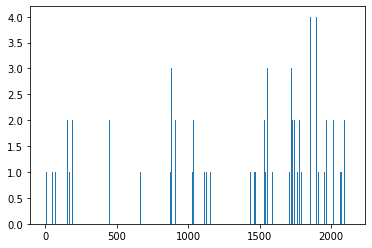

In [ ]:
print("Misclassified images from all 4 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 4]))
print("Misclassified images from 3 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 3]))
print("Misclassified images from 2 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 2]))
print("Misclassified images from 1 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 1]))
plt.bar(range(len(labels)),misclassifications)
plt.show()

In [ ]:
misclassifications_classifier = []
for i in range(len(labels)):
  if labels[i].count(labels[i][0]) == len(labels[i]): # if all classifiers are good ad recognizing the image
    misclassifications_classifier.append([]) 
    continue
  wrong_classifiers = [index for index, predicted_class in enumerate(labels[i]) if predicted_class != labels[i][0]]
  misclassifications_classifier.append(wrong_classifiers) 

In [ ]:
print("Images that are misclassified by all classifiers: ", len([1 for misclassification in misclassifications_classifier if len(misclassification) == 4]))
print("--------")
print("Images that are misclassified only by VGG: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 1 in misclassification]))
print("Images that are correctly classified only by VGG: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 1 not in misclassification]))
print("--------")
print("Images that are misclassified only by ResNet50-1: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 2 in misclassification]))
print("Images that are correctly classified only by ResNet50-1: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 2 not in misclassification]))
print("--------")
print("Images that are misclassified only by ResNet50-2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 3 in misclassification]))
print("Images that are correctly classified only by ResNet50-2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 3 not in misclassification]))
print("--------")
print("Images that are misclassified only by CNN from scratch: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 4 in misclassification]))
print("Images that are correctly classified only by CNN from scratch: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 4 not in misclassification]))

Images that are misclassified by all classifiers:  41
--------
Images that are misclassified only by VGG:  66
Images that are correctly classified only by VGG:  13
--------
Images that are misclassified only by ResNet50-1:  11
Images that are correctly classified only by ResNet50-1:  1
--------
Images that are misclassified only by ResNet50-2:  19
Images that are correctly classified only by ResNet50-2:  12
--------
Images that are misclassified only by CNN from scratch:  91
Images that are correctly classified only by CNN from scratch:  12


In [ ]:
images =  tf.concat([data_batch for data_batch, labels_batch in test_dataset], axis = 0)

#### Misclassified images from all models

In [ ]:
total_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 4]

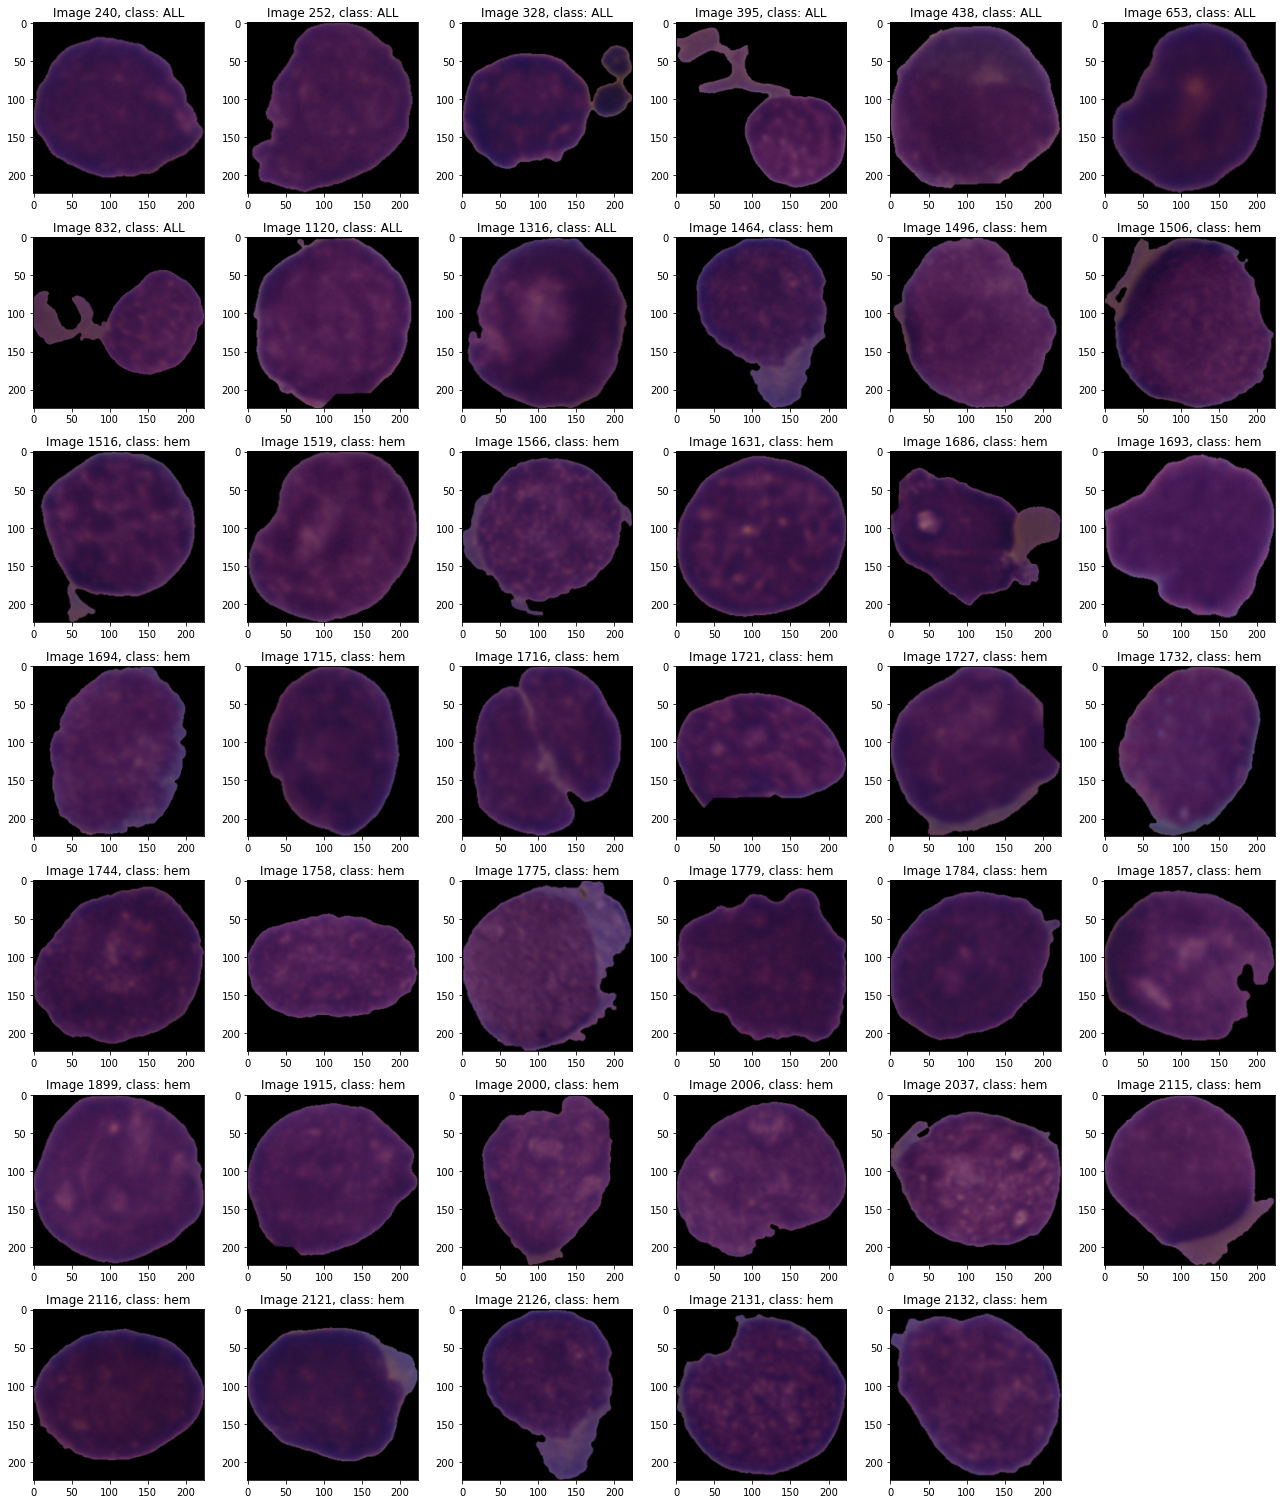

In [ ]:
plot_images(images, total_misclassification_indexes)

### VGG

#### Misclassified images from VGG

In [ ]:
vgg_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 1 in misclassifications_classifier[i]]

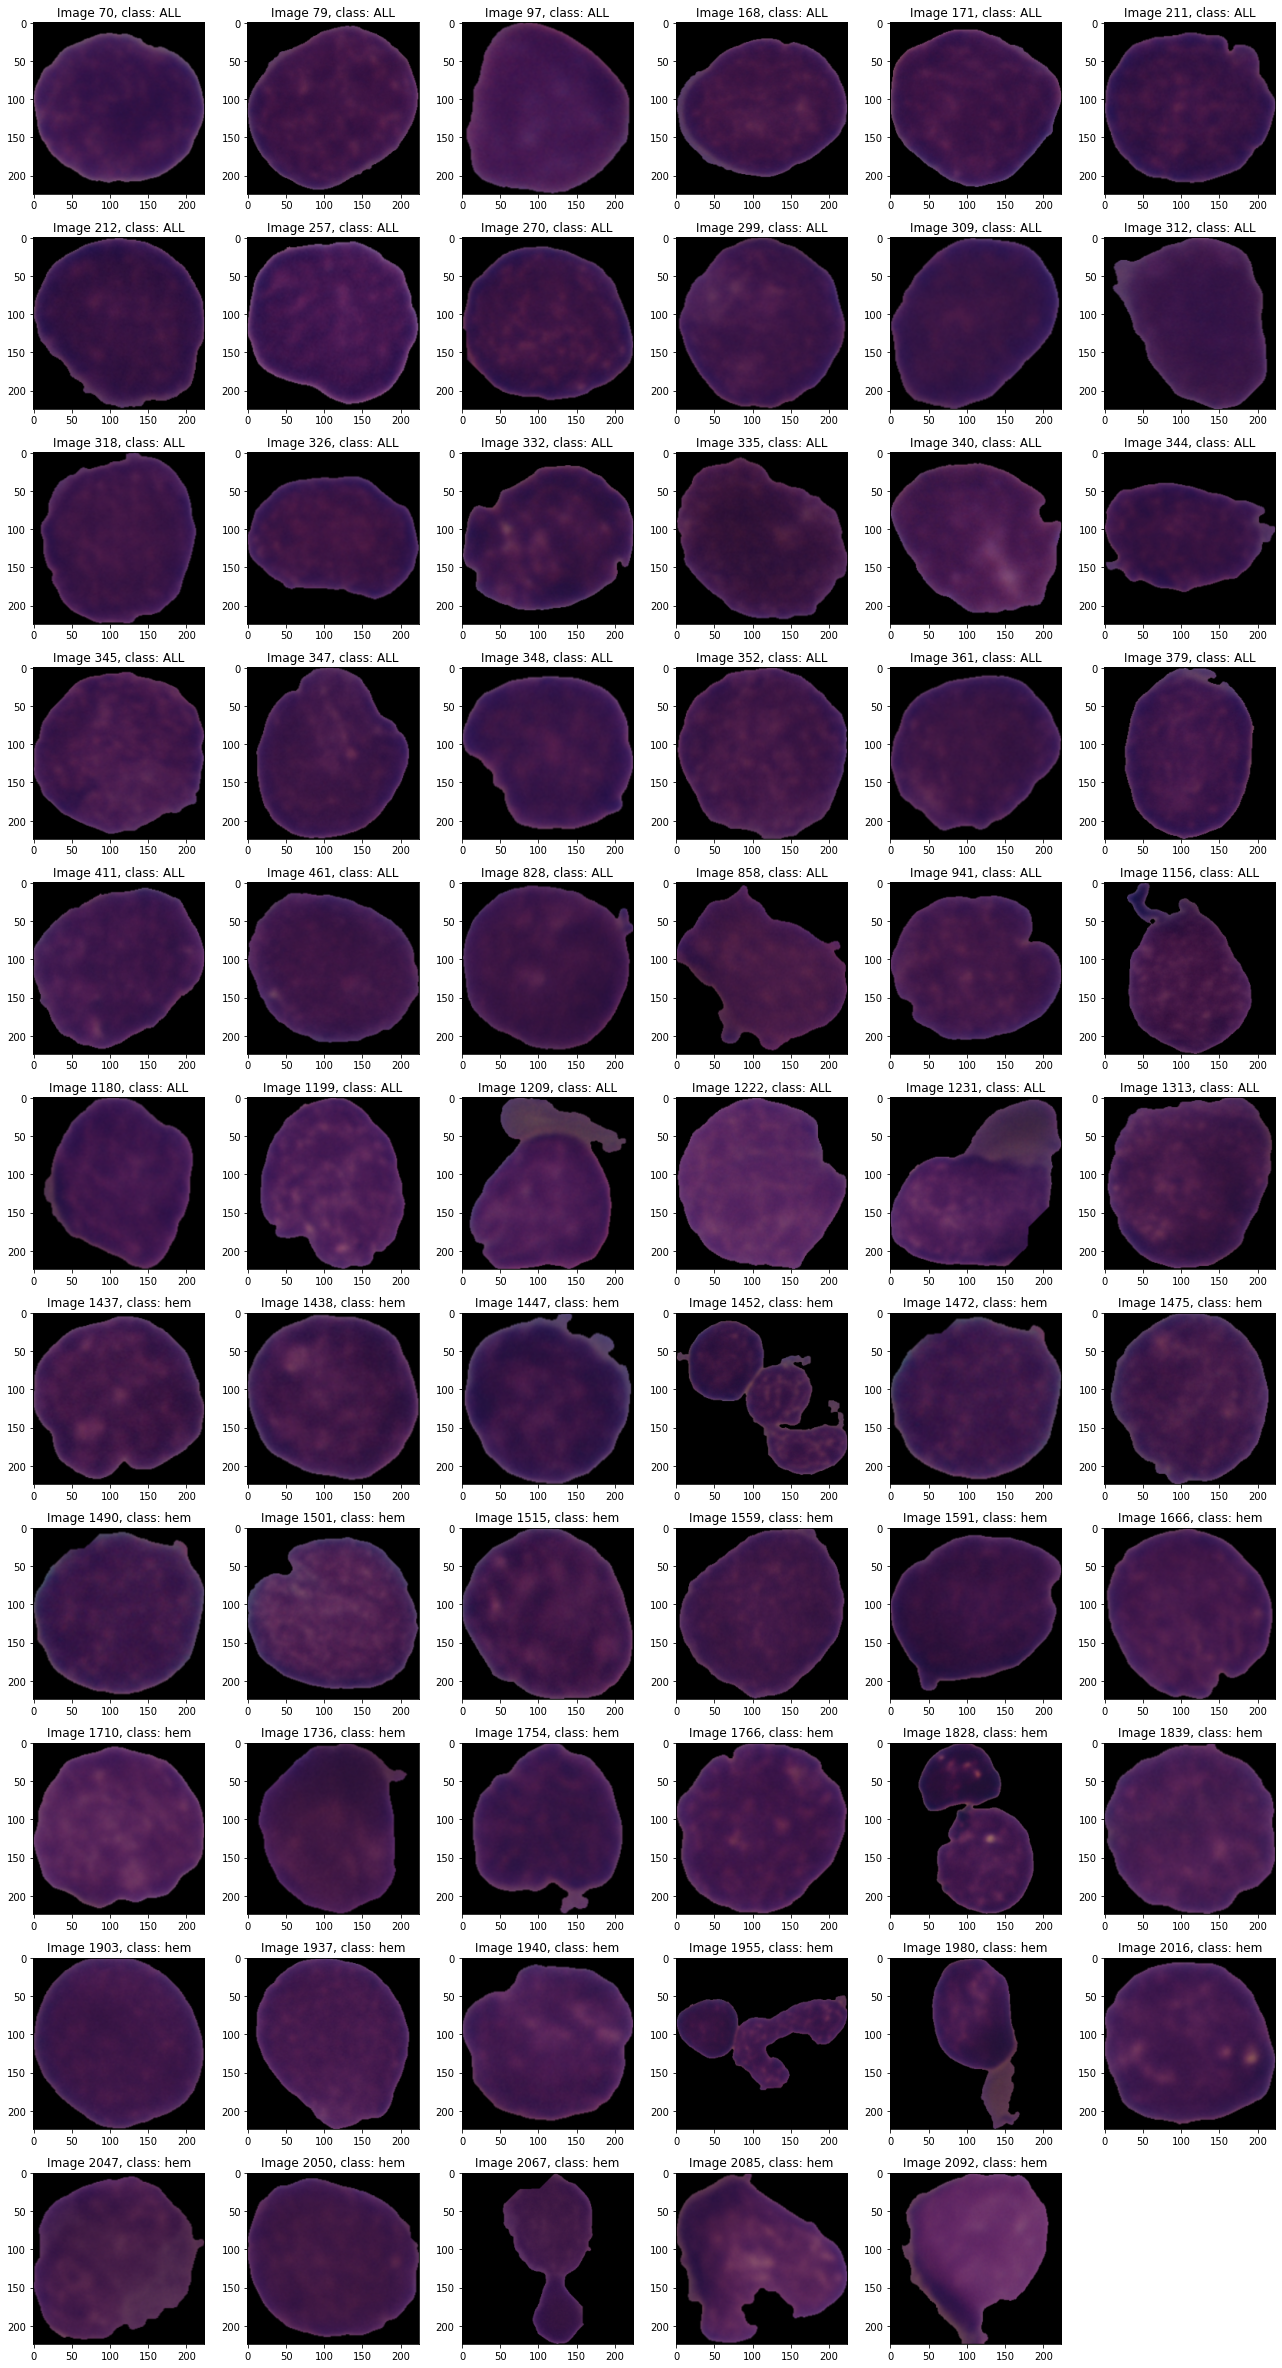

In [ ]:
plot_images(images, vgg_misclassification_indexes)

#### Images correctly classified only from VGG

In [ ]:
vgg_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 3 and 1 not in misclassifications_classifier[i]]

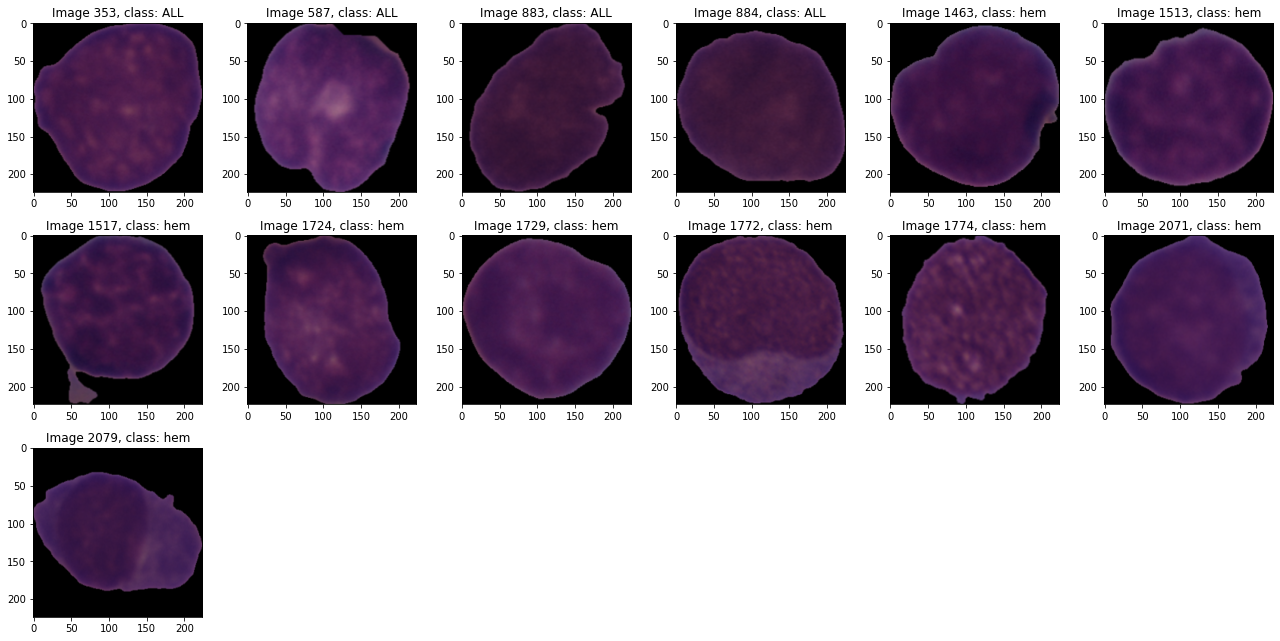

In [ ]:
plot_images(images, vgg_classification_indexes)

### ResNet50 - version 1

#### Misclassified images from ResNet50 - version 1

In [ ]:
resnet1_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 2 in misclassifications_classifier[i]]

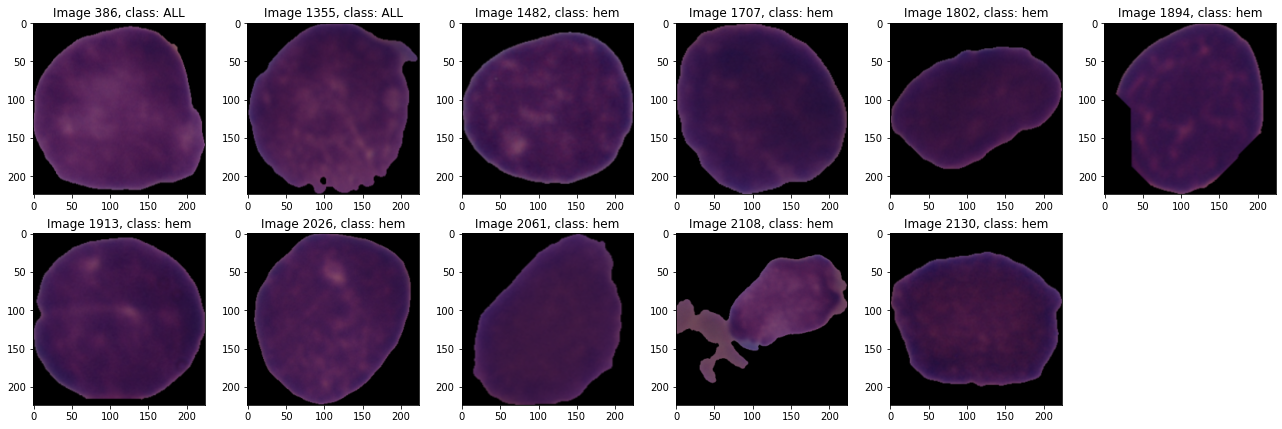

In [ ]:
plot_images(images, resnet1_misclassification_indexes)

#### Images correctly classified only from ResNet50 - version 1

In [ ]:
resnet1_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 3 and 2 not in misclassifications_classifier[i]]

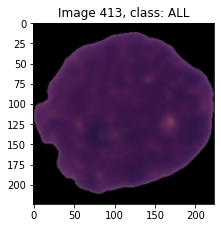

In [ ]:
plot_images(images, resnet1_classification_indexes)

### ResNet50 - version 2

#### Misclassified images from ResNet50 - version 2

In [ ]:
resnet2_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 3 in misclassifications_classifier[i]]

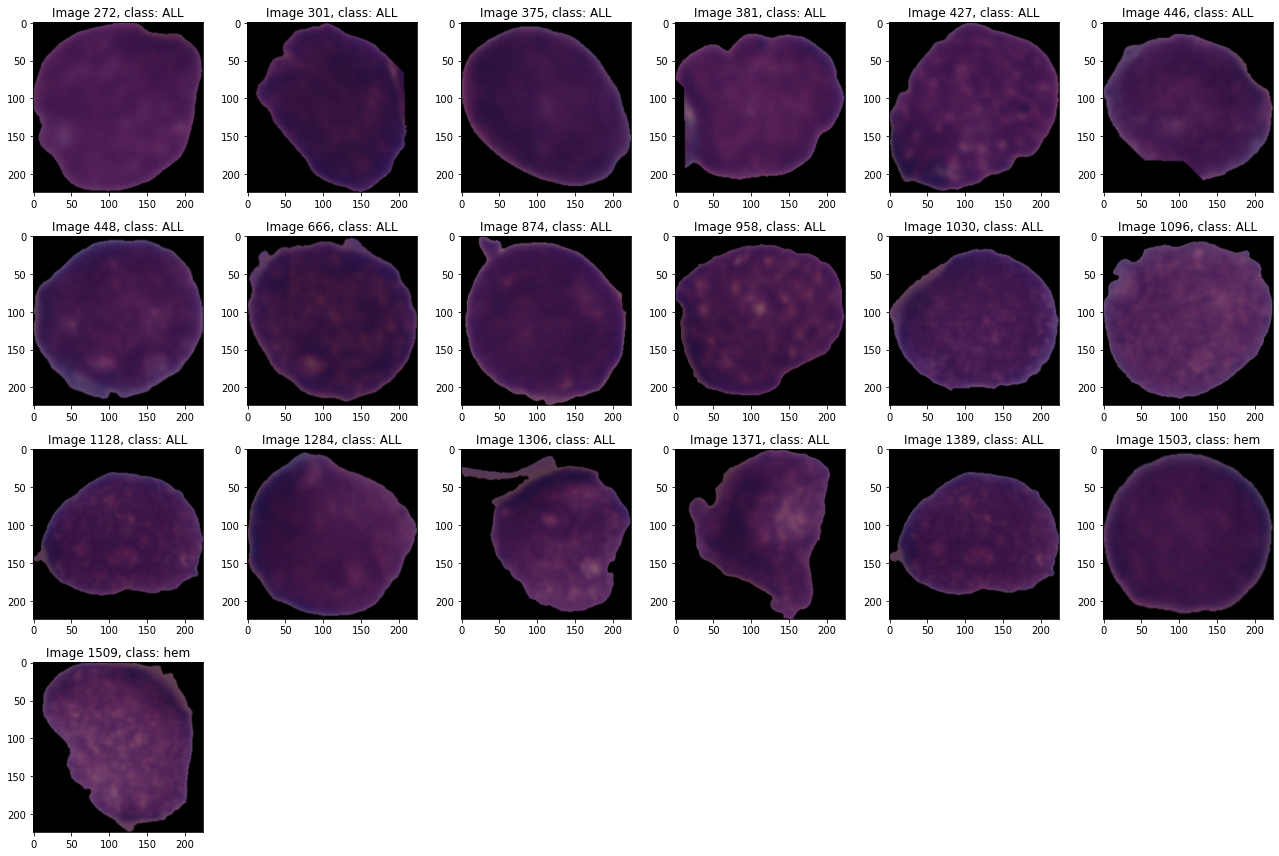

In [ ]:
plot_images(images, resnet2_misclassification_indexes)

#### Images correctly classified only from ResNet50 - version 2

In [ ]:
resnet2_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 3 and 3 not in misclassifications_classifier[i]]

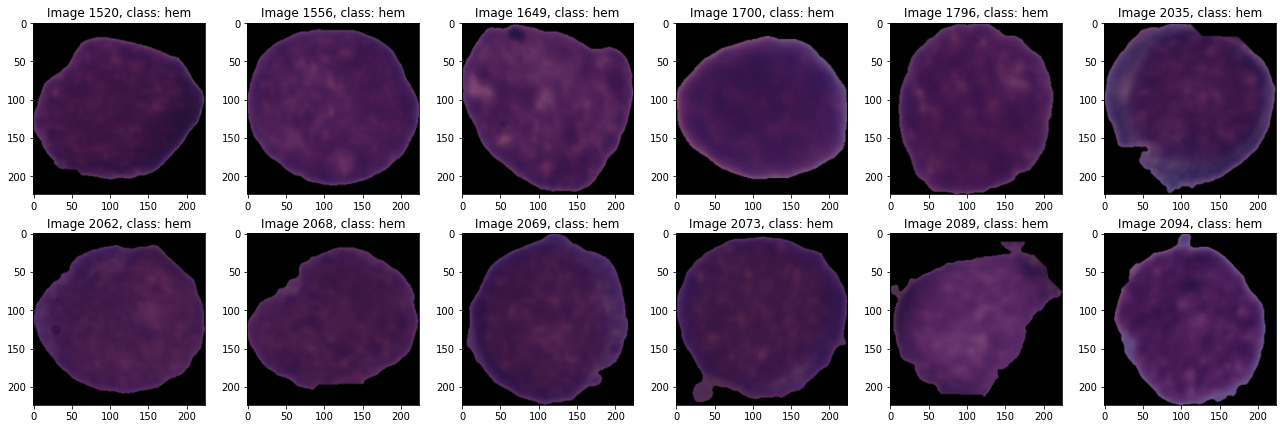

In [ ]:
plot_images(images, resnet2_classification_indexes)

### CNN from scratch

#### Misclassified images from CNN from scratch

In [ ]:
scratch_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 1 and 4 in misclassifications_classifier[i]]

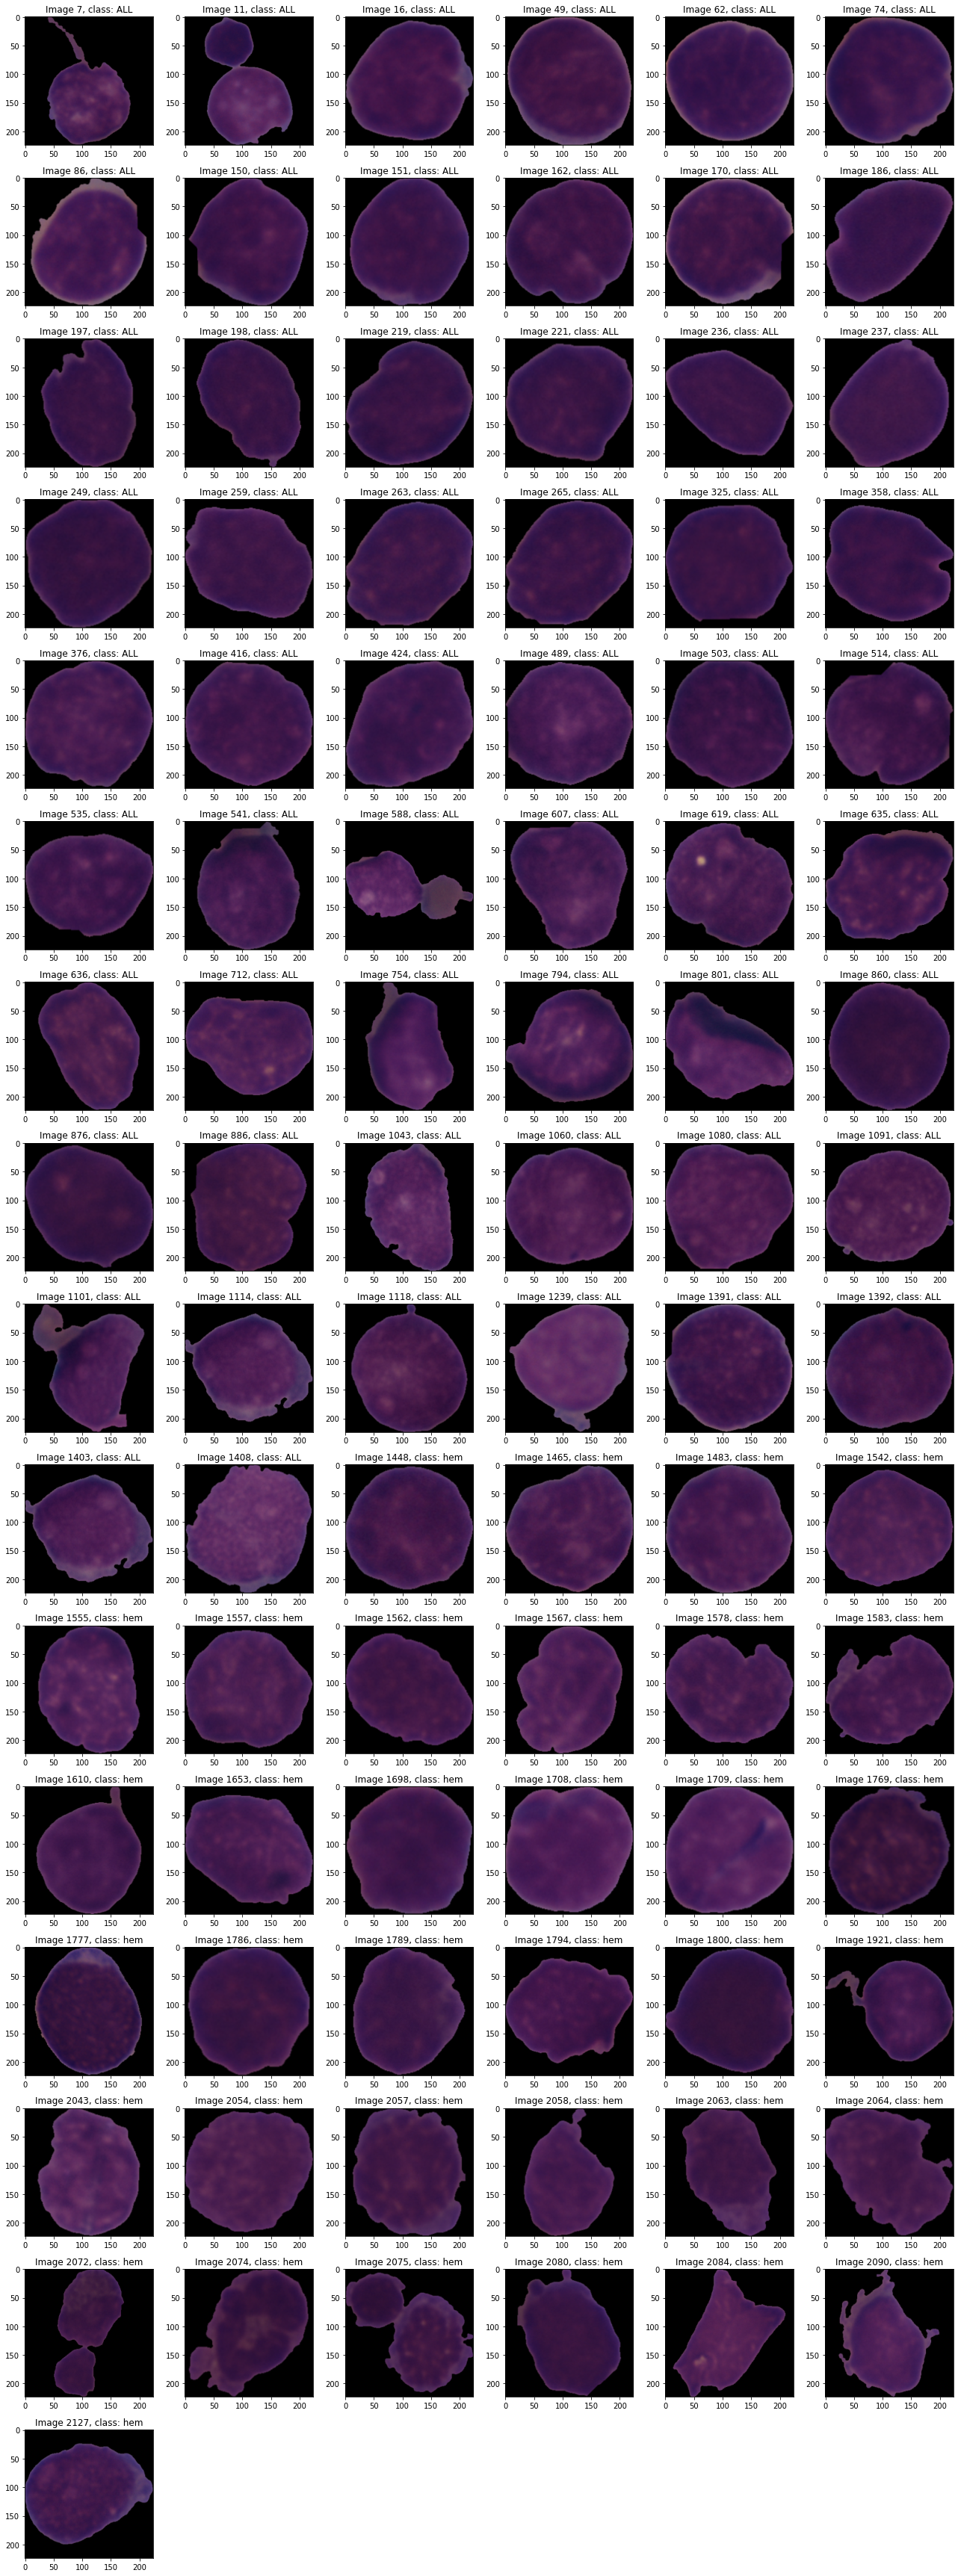

In [ ]:
plot_images(images, scratch_misclassification_indexes)

#### Images correctly classified only from CNN from scratch

In [ ]:
scratch_classification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 3 and 4 not in misclassifications_classifier[i]]

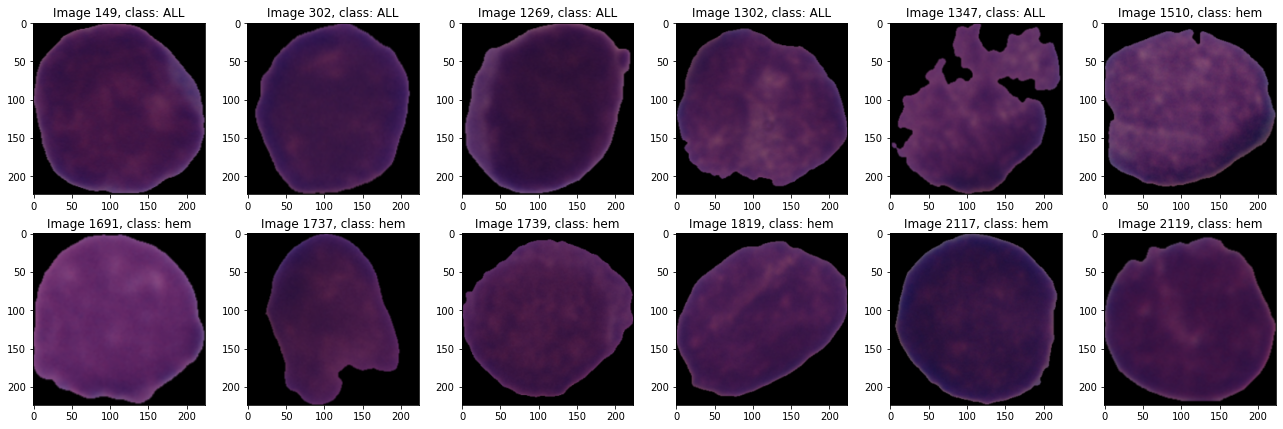

In [ ]:
plot_images(images, scratch_classification_indexes)